# SPGL1 demo

This notebook contains a Python implementation of the original examples from SPGL1 MATLAB solver 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import spdiags
from scipy.sparse.linalg import lsqr as splsqr
from spgl1.lsqr import lsqr
from spgl1 import spgl1, spg_lasso, spg_bp, spg_bpdn, spg_mmv

# Initialize random number generators
np.random.seed(43273289)

In [2]:
# Create random m-by-n encoding matrix and sparse vector
m = 50
n = 128
k = 14
[A,Rtmp] = np.linalg.qr(np.random.randn(n,m),'reduced')
A  = A.T
p  = np.random.permutation(n)
p = p[0:k]
x0 = np.zeros(n)
x0[p] = np.random.randn(k)

Solve the underdetermined LASSO problem for $||x||_1 <= \pi$:

$$min.||Ax-b||_2 \quad subject \quad  to \quad ||x||_1 <= \pi$$

In [3]:
b = A.dot(x0)
tau = np.pi
x,resid,grad,info = spg_lasso(A, b, tau, verbosity=1)

print('%s%s%s' % ('-'*35,' Solution ','-'*35))
print('nonzeros(x) = %i,   ||x||_1 = %12.6e,   ||x||_1 - pi = %13.6e' % \
        (np.sum(abs(x)>1e-5), np.linalg.norm(x,1), np.linalg.norm(x,1)-np.pi))
print('%s%s ' % ('-'*80, '\n'))


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 3.14e+00     
Two-norm of b         : 3.40e+00

Optimality tol        : 1.00e-04     
Target one-norm of x  : 3.14e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      500



EXIT -- Optimal solution found


Products with A     :       1        Total time   (secs) :     0.0
Products with A^H   :       8        Project time (secs) :     0.0
Newton iterations   :       0        Mat-vec time (secs) :     0.0
Line search its     :       0        Subspace iterations :       0
----------------------------------- Solution -----------------------------------
nonzeros(x) = 7,   ||x||_1 = 3.141593e+00,   ||x||_1 - pi =  8.881784e-16
--------------------------------------------------------------------------------
 


Solve the basis pursuit (BP) problem:

$$min.  ||x||_1 \quad subject \quad  to \quad  Ax = b$$


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 0.00e+00     
Two-norm of b         : 3.40e+00

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      500

iterr      Objective   Relative Gap  Rel Error      gNorm   stepG    nnzX    nnzG     tau

    0  3.3978494e+00  0.0000000e+00   1.00e+00  8.995e-01     0.0       0       0  1.2834830e+01
    1  1.4610032e+00  1.6532743e+00   1.00e+00  3.459e-01    -0.6      67       1               
    2  1.2957367e+00  1.4480527e+00   1.00e+00  3.057e-01     0.0      53       1               
    3  1.0445582e+00  1.0186987e+00   1.00e+00  2.394e-01     0.0      33       1               
    4  9.8320803e-01  1.9671347e+00   9.83e-01  3.006e-01     0.0      17       1               
    5  1.0408537e+00  2.7237524e+00   1.00e+00  3.273e-01     0.0      15       1               
    6  8.3766484e-01  4.4627639e

Text(0.5, 1.0, '(a) Basis Pursuit')

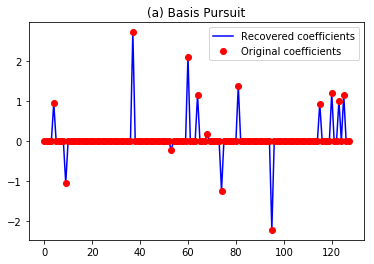

In [4]:
b = A.dot(x0) # signal
x,resid,grad,info = spg_bp(A, b, verbosity=2)

plt.figure()
plt.plot(x,'b')
plt.plot(x0,'ro')
plt.legend(('Recovered coefficients','Original coefficients'))
plt.title('(a) Basis Pursuit')

Text(0, 0.5, '$||r||_2$')

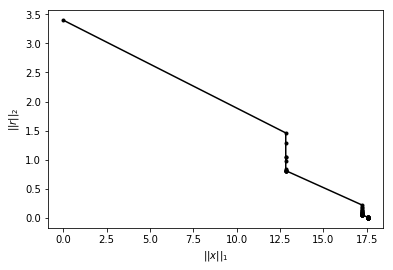

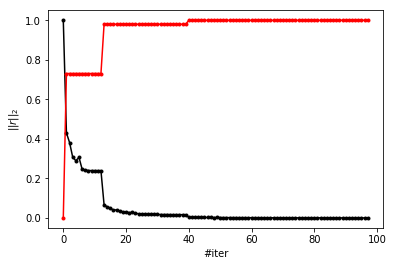

In [5]:
plt.figure()
plt.plot(info['xNorm1'], info['rNorm2'], '.-k')
plt.xlabel(r'$||x||_1$')
plt.ylabel(r'$||r||_2$')

plt.figure()
plt.plot(np.arange(info['iterr']), info['rNorm2']/max(info['rNorm2']), '.-k')
plt.plot(np.arange(info['iterr']), info['xNorm1']/max(info['xNorm1']), '.-r')
plt.xlabel(r'#iter')
plt.ylabel(r'$||r||_2$')

Solve the basis pursuit denoise (BPDN) problem:

$$min. ||x||_1 \quad subject \quad to \quad ||Ax - b||_2 <= 0.1$$


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 0.00e+00     
Two-norm of b         : 3.49e+00

Optimality tol        : 1.00e-04     
Target objective      : 1.00e-01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :       10

iterr      Objective   Relative Gap  Rel Error      gNorm   stepG    nnzX    nnzG     tau

    0  3.4876525e+00  0.0000000e+00   9.71e-01  8.998e-01     0.0       0       0  1.3130733e+01
    1  1.5278506e+00  1.5445083e+00   9.35e-01  3.512e-01    -0.6      70       1               
    2  1.3785367e+00  1.3210423e+00   9.27e-01  3.004e-01     0.0      48       1               
    3  1.1435885e+00  1.0754951e+00   9.13e-01  2.436e-01     0.0      36       1               
    4  1.0650070e+00  1.8808347e+00   9.06e-01  3.058e-01     0.0      24       1               
    5  1.1055544e+00  1.9676460e+00   9.10e-01  2.609e-01     0.0      14       1               
    6  9.7104698e-01  5.0757852e

Text(0.5, 1.0, '(b) Basis Pursuit Denoise')

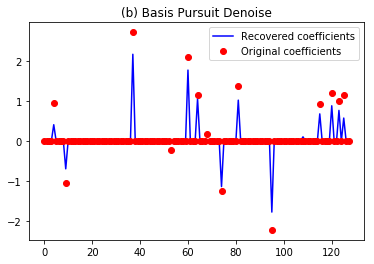

In [6]:
b = A.dot(x0) + np.random.randn(m) * 0.075
sigma = 0.10  #     % Desired ||Ax - b||_2
x,resid,grad,info = spg_bpdn(A, b, sigma, iterations=10, verbosity=2)

plt.figure()
plt.plot(x,'b')
plt.plot(x0,'ro')
plt.legend(('Recovered coefficients','Original coefficients'))
plt.title('(b) Basis Pursuit Denoise')

Solve the basis pursuit (BP) problem in COMPLEX variables:

$$min. ||z||_1 \quad subject \quad to \quad  Az = b$$


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 0.00e+00     
Two-norm of b         : 3.23e+00

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      500

iterr      Objective   Relative Gap  Rel Error      gNorm   stepG    nnzX    nnzG     tau

    0  3.2278608e+00  0.0000000e+00   1.00e+00  9.900e-01     0.0       0       0  1.0524266e+01
    1  1.7448418e+00  1.9165918e+00   1.00e+00  5.168e-01    -0.6      95       0               
    2  1.4600574e+00  1.5883031e+00   1.00e+00  3.875e-01     0.0      57       0               
    3  1.1700012e+00  7.2057823e-01   1.00e+00  2.294e-01     0.0      21       0               
    4  1.1387081e+00  6.0492162e-01   1.00e+00  2.591e-01     0.0      14       0               
    5  1.1192644e+00  6.3143375e-01   1.00e+00  2.339e-01     0.0      13       0               
    6  1.1110267e+00  2.5990247e

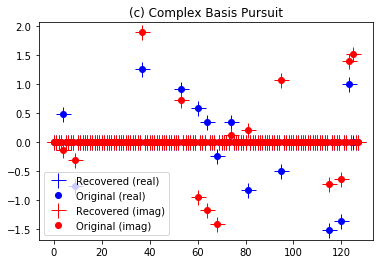

In [7]:
from scipy.sparse.linalg import LinearOperator

class partialFourier(LinearOperator):
    def __init__(self, idx, n):
        self.idx = idx
        self.n = n
        self.shape = (len(idx), n)
        self.dtype = np.complex128
    def _matvec(self, x): 
        # % y = P(idx) * FFT(x)
        z = np.fft.fft(x) / np.sqrt(n)
        return z[idx]
    def _rmatvec(self, x): 
        z = np.zeros(n,dtype=complex)
        z[idx] = x
        return np.fft.ifft(z) * np.sqrt(n)

    
# % Create partial Fourier operator with rows idx
idx = np.random.permutation(n)
idx = idx[0:m]
opA = partialFourier(idx, n)

# % Create sparse coefficients and b = 'A' * z0;
z0 = np.zeros(n,dtype=complex)
z0[p] = np.random.randn(k) + 1j * np.random.randn(k)
b = opA.matvec(z0)

z,resid,grad,info = spg_bp(opA,b, verbosity=2)

plt.figure()
plt.plot(z.real,'b+',markersize=15.0)
plt.plot(z0.real,'bo')
plt.plot(z.imag,'r+',markersize=15.0)
plt.plot(z0.imag,'ro')
plt.legend(('Recovered (real)', 'Original (real)', 'Recovered (imag)', 'Original (imag)'))
plt.title('(c) Complex Basis Pursuit');

Sample the Pareto frontier at 100 points:
  
$$phi(tau) = min. ||Ax-b||_2 \quad subject \quad to \quad ||x|| <= \tau$$

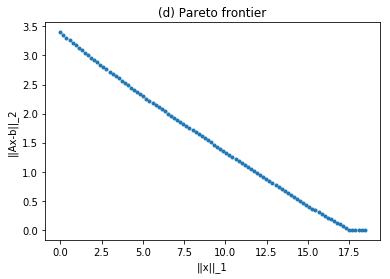

In [8]:
b = A.dot(x0)
x = np.zeros(n)
tau = np.linspace(0, 1.05 * np.linalg.norm(x0, 1), 100)
tau[0] = 1e-10
phi = np.zeros(tau.size)

for i in range(tau.size):
    x,r,grad,info = spgl1(A,b,tau[i],0,x, iterations=1000)
    phi[i] = np.linalg.norm(r)

plt.figure()
plt.plot(tau,phi, '.')
plt.title('(d) Pareto frontier')
plt.xlabel('||x||_1')
plt.ylabel('||Ax-b||_2');

Solve

$$min. ||y||_1 \quad subject \quad  to \quad AW^{-1}y = b$$

and the weighted basis pursuit (BP) problem:

$$min. ||Wx||_1 \quad subject \quad to \quad Ax = b$$

followed by setting $y = Wx$.

Text(0.5, 1.0, '(e) Weighted Basis Pursuit')

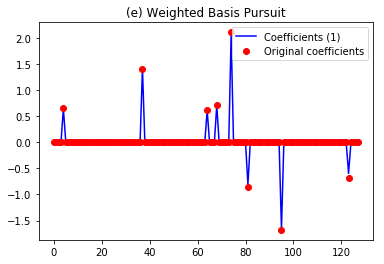

In [9]:
# Sparsify vector x0 a bit more to get exact recovery
k = 9
x0 = np.zeros(n)
x0[p[0:k]] = np.random.randn(k)

# Set up weights w and vector b
w = np.random.rand(n) + 0.1 # Weights
b = A.dot(x0/w) # Signal

x,resid,grad,info = spg_bp(A, b, **dict(iterations=1000, weights=w))
# Reconstructed solution, with weighting
x1 = x * w

plt.figure()
plt.plot(x1,'b')
plt.plot(x0,'ro')
plt.legend(('Coefficients (1)','Original coefficients'))
plt.title('(e) Weighted Basis Pursuit')

Solve the multiple measurement vector (MMV) problem

$$min. ||Y||_{1,2}  \quad subject \quad to \quad  AW^{-1}Y = B$$

and the weighted MMV problem (weights on the rows of X):

$$min. ||WX||_{1,2} \quad subject \quad to \quad AX = B$$

followed by setting $Y = WX$.


SPGL1
No. rows              :      600     
No. columns           :      900

Initial tau           : 0.00e+00     
Two-norm of b         : 2.17e+02

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :     6000



EXIT -- Found a BP solution


Products with A     :    1872        Total time   (secs) :     3.7
Products with A^H   :    1966        Project time (secs) :     0.0
Newton iterations   :      11        Mat-vec time (secs) :     0.0
Line search its     :    1871        Subspace iterations :       0

SPGL1
No. rows              :      600     
No. columns           :      900

Initial tau           : 0.00e+00     
Two-norm of b         : 2.17e+02

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :     6000

iterr      Objective   Relative Gap  Rel Error      gNorm   stepG    nnzX    nnzG     tau

    0  2.1716491e+0

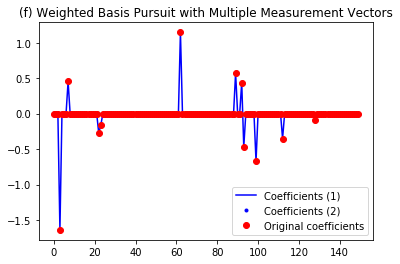

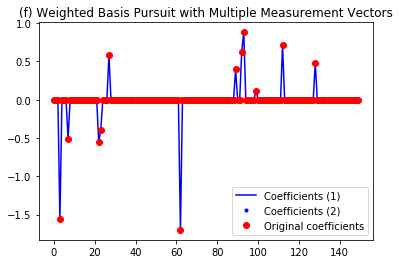

In [10]:
# Create problem
m = 100
n = 150
k = 12
l = 6;
A = np.random.randn(m, n)
p = np.random.permutation(n)[:k]
X0 = np.zeros((n, l))
X0[p, :] = np.random.randn(k, l)

weights = 3 * np.random.rand(n) + 0.1
W = 1/weights * np.eye(n)

B = A.dot(W).dot(X0)

# Solve unweighted version
x_uw, _, _, _ = spg_mmv(A.dot(W), B, 0, **dict(verbosity=1))

# Solve weighted version
x_w, _, _, _ = spg_mmv(A, B, 0, **dict(verbosity=2, weights=weights))
x_w = spdiags(weights, 0, n, n).dot(x_w)

# Plot results
plt.figure()
plt.plot(x_uw[:, 0], 'b-', label='Coefficients (1)')
plt.plot(x_w[:, 0], 'b.', label='Coefficients (2)')
plt.plot(X0[:, 0], 'ro', label='Original coefficients')
plt.legend()
plt.title('(f) Weighted Basis Pursuit with Multiple Measurement Vectors');

plt.figure()
plt.plot(x_uw[:, 1], 'b-', label='Coefficients (1)')
plt.plot(x_w[:, 1], 'b.', label='Coefficients (2)')
plt.plot(X0[:, 1], 'ro', label='Original coefficients')
plt.legend()
plt.title('(f) Weighted Basis Pursuit with Multiple Measurement Vectors');

Let's finally try to compare the internal lsqr with scipy lsqr and perform sgpl1 with subspace minimization

In [11]:
def Aprodfun(A, x, mode):
    if mode == 1:
        y = np.dot(A,x)
    else:
        return np.dot(np.conj(A.T), x)
    return y

 
LSQR            Least-squares solution of  Ax = b
The matrix A has       20 rows  and       10 cols
damp = 1.00000000000000e-05    wantvar =        1
atol = 1.00e-05                 conlim = 1.00e+12
btol = 1.00e-05                 itnlim =      100
 
   Itn      x(1)       r1norm     r2norm  Compatible   LS      Norm A   Cond A
     0  0.00000e+00  1.837e+01  1.837e+01   1.0e+00  3.5e-01
     1  2.55934e-01  5.619e+00  5.619e+00   3.1e-01  2.5e-01  6.7e+00  1.0e+00
     2  8.35801e-01  2.113e+00  2.113e+00   1.1e-01  7.1e-02  8.8e+00  2.1e+00
     3  1.02307e+00  1.172e+00  1.172e+00   6.4e-02  3.9e-02  1.0e+01  3.3e+00
     4  1.07123e+00  5.373e-01  5.373e-01   2.9e-02  1.7e-02  1.1e+01  4.7e+00
     5  1.03281e+00  2.622e-01  2.622e-01   1.4e-02  6.8e-03  1.2e+01  6.1e+00
     6  1.01731e+00  8.979e-02  8.979e-02   4.9e-03  2.0e-03  1.3e+01  7.7e+00
     7  1.01060e+00  6.333e-02  6.333e-02   3.4e-03  1.7e-03  1.3e+01  8.9e+00
     8  9.99827e-01  2.831e-03  2.831e-03   1.5e-04  

(0, 2)

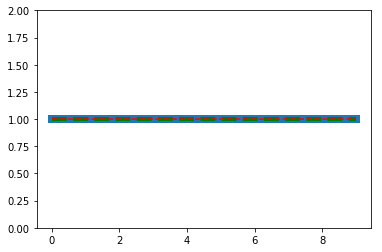

In [12]:
n = 10
m = 20
A = np.random.normal(0, 1, (m, n))
Aprod = lambda x, mode: Aprodfun(A, x, mode)
x = np.ones(n)
y = A.dot(x)

damp       = 1e-5
aTol       = 1e-5
bTol       = 1e-5
conLim     = 1e12
itnMaxLSQR = 100
showLSQR   = 2

xinv, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = \
    lsqr(m, n, Aprod, y, damp, aTol, bTol, conLim, itnMaxLSQR, showLSQR)
      
xinv_sp, istop_sp, itn_sp, r1norm_sp, r2norm_sp, anorm_sp, acond_sp, arnorm_sp, xnorm_sp, var = \
    splsqr(A, y, damp, aTol, bTol, conLim, itnMaxLSQR, showLSQR)

print('istop=%d, itn=%d, r1norm=%.2f, '
      'r2norm=%.2f, anorm=%.2f, acond=%.2f, arnorm=%.2f, xnorm=%.2f' \
      %(istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm))

print('istop=%d, itn=%d, r1norm=%.2f, '
      'r2norm=%.2f, anorm=%.2f, acond=%.2f, arnorm=%.2f, xnorm=%.2f' \
      %(istop_sp, itn_sp, r1norm_sp, r2norm_sp, anorm_sp, acond_sp, arnorm_sp, xnorm_sp))

plt.plot(x, lw=8)
plt.plot(xinv, '--g', lw=4)
plt.plot(xinv_sp, '--r')
plt.ylim(0, 2)

And use subspace minimization in SPGL1


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 0.00e+00     
Two-norm of b         : 2.35e+00

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      500

iterr      Objective   Relative Gap  Rel Error      gNorm   stepG    nnzX    nnzG     tau

    0  2.3464508e+00  0.0000000e+00   1.00e+00  7.079e-01     0.0       0       0  7.7777690e+00
    1  1.2012188e+00  1.1437071e+00   1.00e+00  3.189e-01    -0.6      72       1               
    2  1.0579716e+00  7.0833753e-01   1.00e+00  2.535e-01     0.0      46       1               
    3  9.0678491e-01  4.5393961e-01   9.07e-01  1.860e-01     0.0      26       1               
    4  8.5672660e-01  5.2398586e-01   8.57e-01  2.118e-01     0.0      22       1               
    5  8.4108071e-01  8.5864889e-01   8.41e-01  2.082e-01     0.0      18       1               
    6  7.9025435e-01  1.5209591e

Text(0.5, 1.0, '(a) Basis Pursuit')

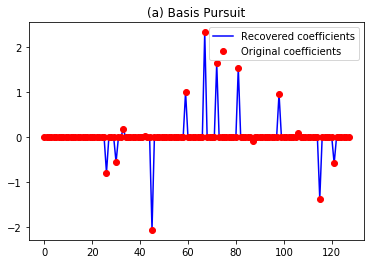

In [15]:
# Create random m-by-n encoding matrix and sparse vector
m = 50
n = 128
k = 14
[A,Rtmp] = np.linalg.qr(np.random.randn(n,m),'reduced')
A  = A.T
p  = np.random.permutation(n)
p = p[0:k]
x0 = np.zeros(n)
x0[p] = np.random.randn(k)

# Basis pursuit with subspace minimization
b = A.dot(x0) # signal
x,resid,grad,info = spg_bp(A, b, subspaceMin=True, verbosity=2)

plt.figure()
plt.plot(x,'b')
plt.plot(x0,'ro')
plt.legend(('Recovered coefficients','Original coefficients'))
plt.title('(a) Basis Pursuit')